## Semantic Search

**Semantic search denotes search with meaning**, as distinguished from traditional search where the search engine looks for literal matches of the query words or variants of them, without understanding the overall meaning of the query.

In this class, we will use the CLIP model to perform semantic search. That is, given a text query, we will return the images that are most relevant to the query. To do so, we need to:

1. Calculate vector embeddings for all of the images in our dataset;
2. Calculate a vector embedding for a user query (i.e. "cat" or "dog") and;
3. Compare the text embedding to the image embeddings to find the closest embeddings.
   
The closer two embeddings are, the more similar the documents they represent are.

![img](images/semantic_search.png)

Some applications of semantic search in business contexts include:

1. Improved Customer Experience: With semantic search, businesses can enhance the customer experience by providing more accurate and relevant search results, thus reducing time and effort spent in finding the right products or services.

2. Personalized Marketing: Semantic search can be applied in marketing to understand customer behavior and preferences, enabling businesses to develop personalized marketing strategies and improve customer engagement. 

3. Content Management: Semantic search can be applied in content management systems to organize and categorize content more efficiently based on their semantic connections. 

4. Product Recommendation: E-commerce businesses can use semantic search to improve their product recommendation systems, thereby increasing sales and customer satisfaction.

5. Enhanced SEO: Businesses can optimize their websites for semantic search, which can help improve their rankings on search engine result pages and increase visibility.


There are also a lot of start-ups devoted to semantic search, see a list at https://wellfound.com/startups/industry/semantic-search

**Exercise** Let's implement a simple semantic search using the CLIP model.

Complete the following code to compute the image embedding vector for each of the images in the `dog_examples` folder.

Then, create a matrix of size N_images x 512, with each row being the image embedding vector.

In [33]:
import torch
import clip
import numpy as np
import pandas as pd

from PIL import Image

import glob

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [34]:
image_paths = glob.glob("dog_examples/*")
image_paths

['dog_examples/German-Shepherd-dog-Alsatian.jpg.webp',
 'dog_examples/dog2.png',
 'dog_examples/dog1.png',
 'dog_examples/Chart_rosyjski_borzoj_rybnik-kamien_pl.jpg',
 'dog_examples/shiba-inu-hund.jpg',
 'dog_examples/GettyImages-1454565264-e1701120522406.jpg.webp',
 'dog_examples/GettyImages-157603001-e1701106766955.jpg.webp',
 'dog_examples/98.jpg.webp',
 'dog_examples/Pitbull_6,_2012.jpg',
 'dog_examples/Yorkshire Terrier.jpg.webp']

In [35]:
image_features_list = []

for image_path in image_paths:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    image_features = image_features

    image_features_list.append(image_features)

image_embedding_matrix = torch.cat(image_features_list, dim=0)

In [36]:
image_embedding_matrix.shape

torch.Size([10, 512])

Now, create a function, that given a string representing a **text query**, computes the similarity with each of the images, and returns the closest index to the query.

In [38]:
def search(text_query):
    text = clip.tokenize([text_query]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text)

    text_features /= text_features.norm(dim=-1, keepdim=True)

    image_text_similarity = image_embedding_matrix @ text_features.T

    # the closest index is the one with the highest similarity
    best_image_index = image_text_similarity.argmax().item()
    
    return best_image_index

#### Some sample queries

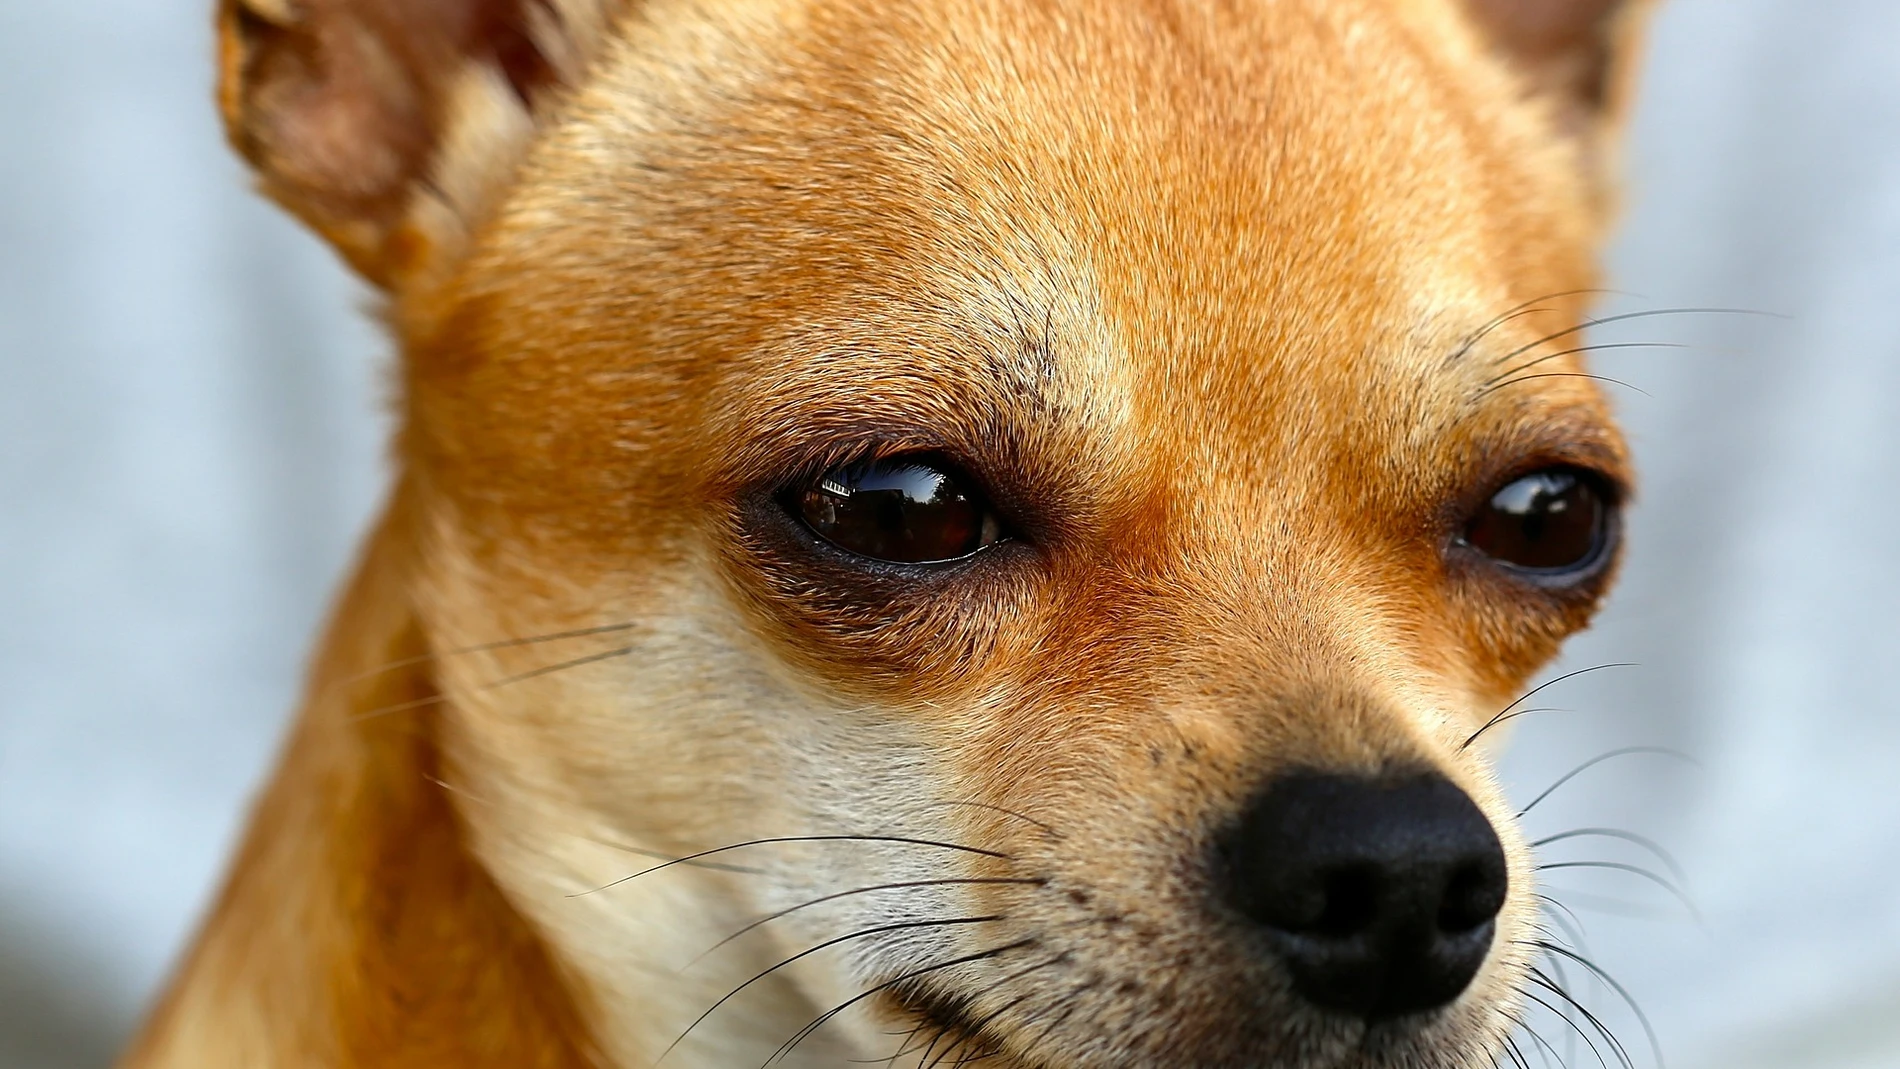

In [39]:
query = "A chihuahua"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

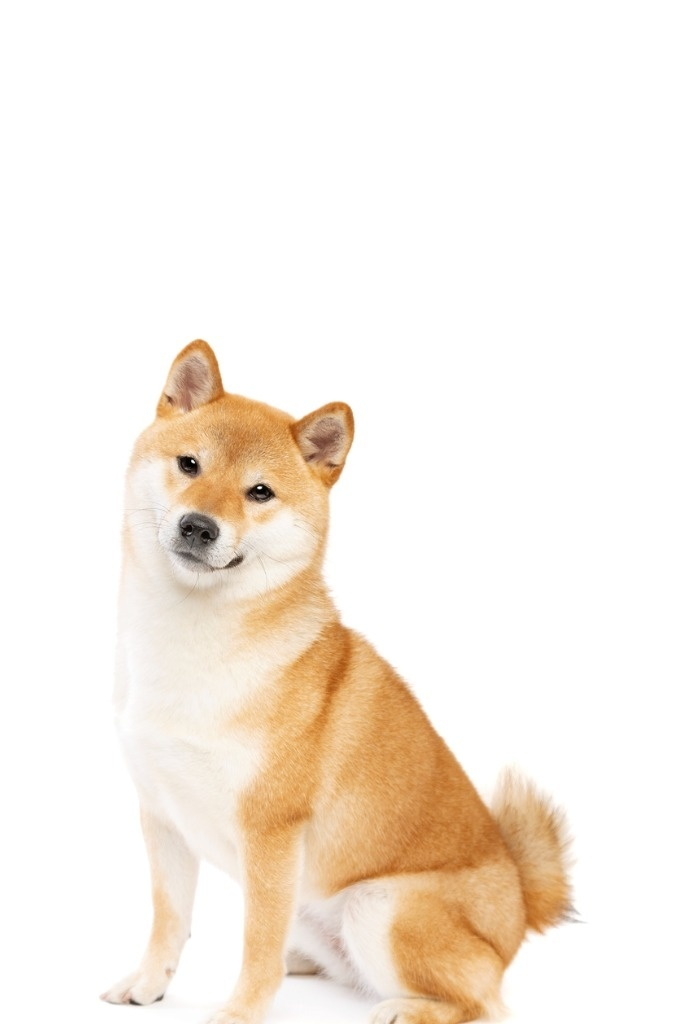

In [40]:
query = "A shiba inu"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

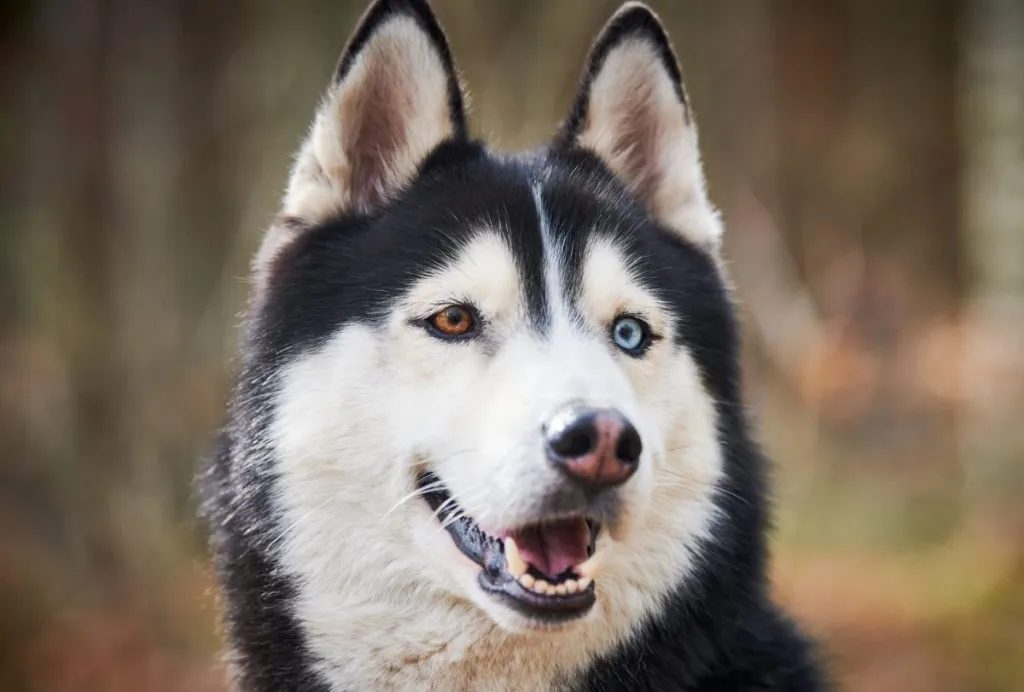

In [41]:
query = "A husky"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

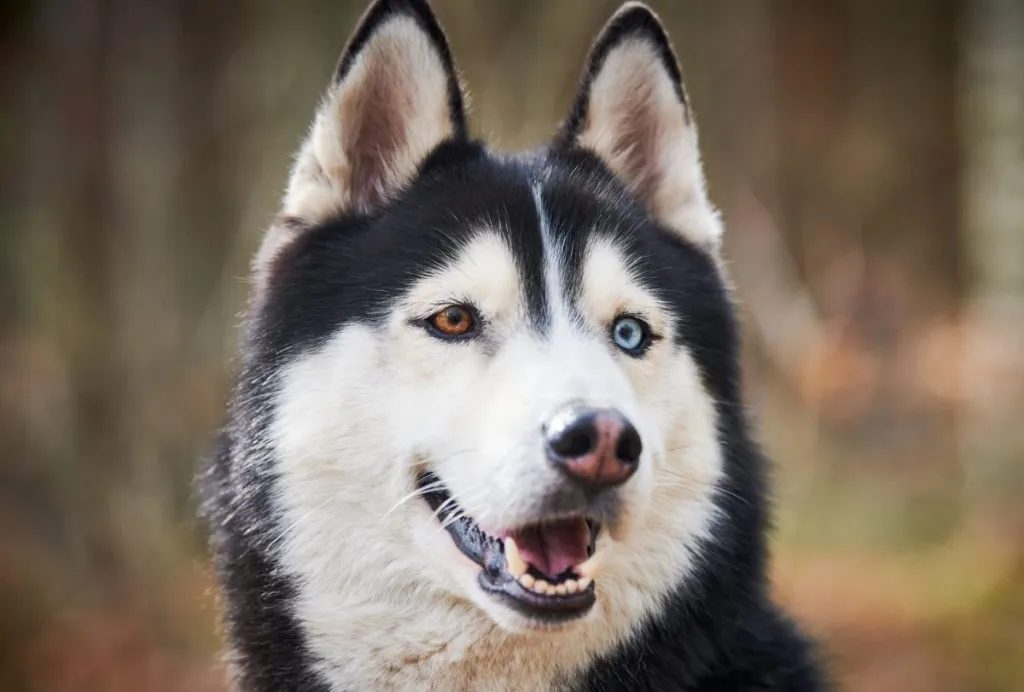

In [42]:
query = "A wolf"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

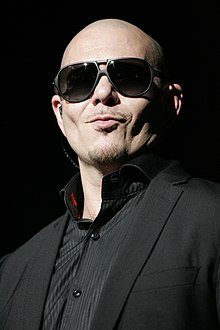

In [43]:
query = "A pitbull"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

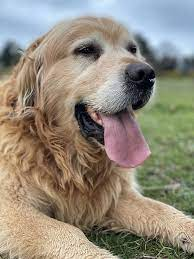

In [44]:
query = "The happiest dog of all!"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

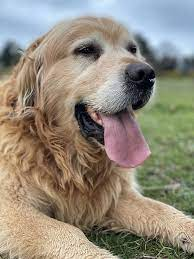

In [45]:
query = "Who's a good boy?"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

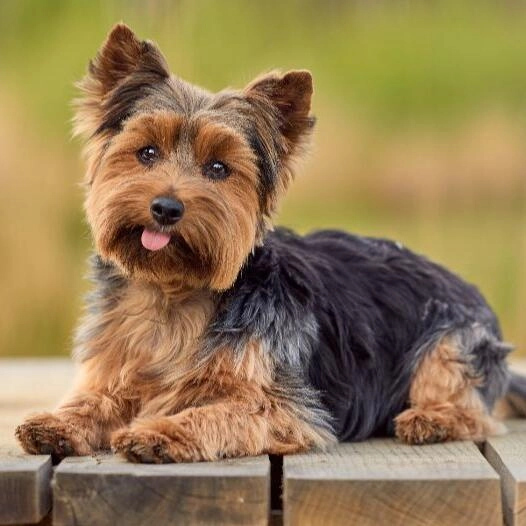

In [52]:
query = "A yorkie"

best_image_index = search(query)

best_image = Image.open(image_paths[best_image_index])

best_image

### A full Semantic Search application

The previous example was fine to learn how semantic search works, but our dataset only consisted in 10 images.

Now, we will use a dataset of ~2.000.000 images from Unsplash, https://unsplash.com

Fortunately, the image embeddings have already been computed (it takes a few hours), so we can just load the vector matrix for the images

The following command downloads a table with the image position (0, 1, 2) and the corresponding URL code

In [ ]:
!wget https://github.com/haltakov/natural-language-image-search/releases/download/1.0.0/photo_ids.csv -O photo_ids.csv

The following command downloads the image embedding matrix of all the images

In [ ]:
!wget https://github.com/haltakov/natural-language-image-search/releases/download/1.0.0/features.npy -O features.npy

In [53]:
import torch
import clip
import numpy as np
import pandas as pd

In [54]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

We load the previous embedding matrix and check the dimensions

In [55]:
embeddings_matrix = np.load('features.npy')
embeddings_matrix = torch.tensor(embeddings_matrix).float().to(device)

In [56]:
embeddings_matrix.shape

torch.Size([1981161, 512])

In [57]:
photo_ids = pd.read_csv("photo_ids.csv")
photo_ids = list(photo_ids['photo_id'])

In [58]:
len(photo_ids)

1981161

In [59]:
def encode_text_query(text_query):
  with torch.no_grad():
    
    text_encoded = model.encode_text(clip.tokenize(text_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)  # normalize the text features

  return text_encoded

In [60]:
def find_best_matches(text_features, photo_features, photo_ids, results_count=3):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score
  best_photo_idx = (-similarities).argsort()

  # Return the photo IDs of the best matches
  return [photo_ids[i] for i in best_photo_idx[:results_count]]

In [61]:
from IPython.display import Image
from IPython.core.display import HTML

def display_photo(photo_id):
  # Get the URL of the photo resized to have a width of 320px
  photo_image_url = f"https://unsplash.com/photos/{photo_id}/download?w=320"

  # Display the photo
  display(Image(url=photo_image_url))

  # Display the attribution text
  display(HTML(f'Photo on <a target="_blank" href="https://unsplash.com/photos/{photo_id}">Unsplash</a> '))
  print()

In [62]:
def search(search_query, photo_features, photo_ids, results_count=3):
  # Encode the search query
  text_features = encode_text_query(search_query)

  # Find the best matches
  best_photo_ids = find_best_matches(text_features, photo_features, photo_ids, results_count)

  # Display the best photos
  for photo_id in best_photo_ids:
    display_photo(photo_id)


#### Some example queries

In [63]:
search_query = "A dog playing in the garden"

search(search_query, embeddings_matrix, photo_ids, 3)

In [64]:
search_query = "A dog playing in the snow"

search(search_query, embeddings_matrix, photo_ids, 3)

In [65]:
search_query = "A tiger playing in the snow"

search(search_query, embeddings_matrix, photo_ids, 3)

In [66]:
search_query = "Roman aqueduct from Segovia"

search(search_query, embeddings_matrix, photo_ids, 3)

In [67]:
search_query = "The feeling when the classes are over and you can finally relax"

search(search_query, embeddings_matrix, photo_ids, 1)

In [69]:
search_query = "IE University student"

search(search_query, embeddings_matrix, photo_ids, 3)

In [72]:
search_query = "A castle in the sky"

search(search_query, embeddings_matrix, photo_ids, 3)

**Exercise** Write a text query in which the first photo returned is not relevant / an error.

## More applications of Semantic Search

Semantic Search can be specially useful when the image collection belongs to a particular domain.

For example, here you can try another semantic search application using CLIP over a dataset of 80.000 art paintings:

https://art-explorer.komorebi.ai